In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files

import matplotlib.pyplot as plt   #plots
import matplotlib.cm as cm        #plots
import matplotlib.colors as colors   #plots

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

from sklearn.cluster import KMeans   #for clustering


# Exploratory analysis and data preparation:

## Obtention and preparation of the datasets

## Zip codes and geographical coordinates preparation - ‘hartford_geo’ data frame:

### For getting all zip codes in Hartford, the  US Zip Code Latitude and Longitude dataset has been accessed, using the response for an API call to   https://public.opendatasoft.com/ page. As the data is in Json format and it corresponds to the whole Connecticut state, some additional preparation has to be performed

In [2]:
url1 = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&rows=443&facet=timezone&facet=Hartford&facet=CT&refine.state=CT'

resp = requests.get(url1).json()
resp.keys()

dict_keys(['nhits', 'parameters', 'records', 'facet_groups'])

In [3]:
#relevant data is in 'fields' nested dictionary

#structure of json file:
resp['records'][0]    #each change in list element is a new zipcode
resp['records'][0]['fields']    #for each change, this level of nest whose info is necessary

{'city': 'Windsor',
 'zip': '06095',
 'dst': 1,
 'geopoint': [41.857303, -72.66654],
 'longitude': -72.66654,
 'state': 'CT',
 'latitude': 41.857303,
 'timezone': -5}

### As relevant data is nested in the json file, this preparation gets a list with the 4 columns of interest

In [4]:
lzipgeo=[]
listct = resp['records']
for eachcity in range(len(listct)):                     #iterate to get all cities
    citydict = listct[eachcity]['fields']   #get to nesting level (dictionary),eachcity changes
    innerlist=[]                           #will capture all dictionary content in a list
    for dickey in citydict:               #iterate through dictionary
        if (dickey=='city' or dickey=='zip' or dickey=='longitude' or dickey=='latitude'): #only relevant
            innerlist.append(citydict[dickey])           #internal list (row)
    lzipgeo.append(innerlist)                    #list of rows
lzipgeo[:8]
    

[['Windsor', '06095', -72.66654, 41.857303],
 ['W Hartford', '06127', -72.718832, 41.791776],
 ['Hartford', '06123', -72.718832, 41.791776],
 ['W Hartford', '06110', -72.73374, 41.7313],
 ['Norwalk', '06860', -73.363661, 41.308873],
 ['Danielson', '06239', -71.87594, 41.799111],
 ['East Hartland', '06027', -72.90922, 42.002345],
 ['Hamden', '06518', -72.90409, 41.413114]]

### Forge list into a data frame

In [5]:
zipstate = pd.DataFrame(lzipgeo, columns=['City', 'Zip Code', 'longitude', 'latitude'])
zipstate.tail()

,City,Zip Code,longitude,latitude
438,Riverton,06065,-73.018590,41.961127
439,Danbury,06817,-73.363661,41.308873
440,Quinebaug,06262,-71.946710,42.022904
441,Bridgeport,06606,-73.207710,41.209496
442,East Hartford,06118,-72.608070,41.745349


### Towns and cities in Hartford, Connecticut:

### The zip codes data frame does not have the information about the towns belonging  to Connectitut states, an addditional source is used to merge and make additional preparation to have all Towns and its corresponding coordinates. The source of this information is https://www.zipcodestogo.com

In [6]:
url2 = 'https://www.zipcodestogo.com/Connecticut/'
townlist = pd.read_html(url2, header=0)

In [7]:
print(townlist[1].shape[0])
townlist[1].head()   #notice that the desired table is in [1]

439


,Zip Codes for the State of Connecticut,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Zip Code,City,County,Zip Code Map
1,06001,Avon,Hartford,View Map
2,06002,Bloomfield,Hartford,View Map
3,06006,Windsor,Hartford,View Map
4,06010,Bristol,Hartford,View Map


In [8]:
# set column names
townlist[1].columns=townlist[1].iloc[0]
towndf = townlist[1]
towndf.drop(0, inplace=True)
towndf.head()  

,Zip Code,City,County,Zip Code Map
1,06001,Avon,Hartford,View Map
2,06002,Bloomfield,Hartford,View Map
3,06006,Windsor,Hartford,View Map
4,06010,Bristol,Hartford,View Map
5,06011,Bristol,Hartford,View Map


In [9]:
towndf.set_index('Zip Code', drop=True, inplace=True)

### After format adjustments,  ignore irrelevant columns

In [10]:
#drop repeating col
towndf.drop('Zip Code Map', 1, inplace=True)
towndf.tail()

,City,County
Zip Code,,
06922,Stamford,Fairfield
06925,Stamford,Fairfield
06926,Stamford,Fairfield
06927,Stamford,Fairfield
06928,Stamford,Fairfield


### ...and filter out all cities that does not belog to Hartford county

In [11]:
#limit to just the hartford county
hartford = towndf[towndf['County']=='Hartford']
hartford.tail(6)

,City,County
Zip Code,,
06199,Hartford,Hartford
06444,Marion,Hartford
06447,Marlborough,Hartford
06467,Milldale,Hartford
06479,Plantsville,Hartford
06489,Southington,Hartford


In [12]:
#get one per city
hartford = hartford[~hartford['City'].duplicated()]

In [13]:
print('There are {} cities in Hartford'.format(hartford.shape[0]))

There are 49 cities in Hartford


### Then, both tables are merged on Zip Code, having the data frame with all cities and its coordinates which will be used for exploring the venues of interest

In [14]:
hartford_geo = hartford
hartford_geo = pd.merge(hartford_geo, zipstate, on="Zip Code", how='inner')
hartford_geo.columns

Index(['Zip Code', 'City_x', 'County', 'City_y', 'longitude', 'latitude'], dtype='object')

In [15]:
#fix columns and change the index
hartford_geo.drop(['City_y'], 1, inplace=True)
hartford_geo.rename(columns={"City_x":"City"}, inplace=True)
hartford_geo.set_index("City", drop=True, inplace=True)
hartford_geo.head()


,Zip Code,County,longitude,latitude
City,,,,
Avon,06001,Hartford,-72.864310,41.789698
Bloomfield,06002,Hartford,-72.726420,41.832798
Windsor,06006,Hartford,-72.734271,41.879637
Bristol,06010,Hartford,-72.933650,41.682249
Burlington,06013,Hartford,-72.946420,41.758415


In [16]:
hartford_geo.tail()

,Zip Code,County,longitude,latitude
City,,,,
Marion,06444,Hartford,-72.718832,41.791776
Marlborough,06447,Hartford,-72.462520,41.637066
Milldale,06467,Hartford,-72.903746,41.565697
Plantsville,06479,Hartford,-72.896960,41.575847
Southington,06489,Hartford,-72.871030,41.612298


In [17]:
print('Coordinates were obtained for each city')

Coordinates were obtained for each city


## Price of real estate data set preparation - ‘cityprices’ data frame:

### Also important for the analysis, is the  dataset containing historic the prices of real estate sales, as it is one important election criterion is the price. The dataset contains all real estate sales carried out in Connectitut, it has been extracted from https://catalog.data.gov/dataset/real-estate-sales-2001-2016

In [18]:
prices = pd.read_csv('Real_Estate_Sales_2001-2017.csv')
prices.head()   

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
0,815906,170177,2017,04/05/1999 12:00:00 AM,New London,293 PEQUOT AVE,132440.0,252500.0,0.525000,NaN,Two Family,NaN,NaN
1,2,900035,2009,07/20/2010 12:00:00 AM,Andover,1 DOGWOOD DRIVE,55600.0,99000.0,0.561616,Vacant Land,NaN,NaN,NaN
2,3,14011,2014,01/14/2015 12:00:00 AM,Andover,1 JUROVATY LANE,153100.0,190000.0,0.805789,Residential,Single Family,NaN,NaN
3,4,80009,2008,01/21/2009 12:00:00 AM,Andover,1 ROSE LANE,116600.0,138900.0,0.839453,Residential,Single Family,NaN,NaN
4,5,15006,2015,11/30/2015 12:00:00 AM,Andover,1 ROSE LANE,102900.0,50000.0,2.058000,Residential,Single Family,14 - Foreclosure,PROPERTY WAS OWNED BY THE BANK


### Taking into consideration the objective of the analysis, all residential property has to be ignored. For having a realistic proxy for recent prices, the years before 2015 won't be included.

In [19]:
print(prices.shape)
prices.columns

(861597, 13)


Index(['ID', 'SerialNumber', 'ListYear', 'DateRecorded', 'Town', 'Address',
       'AssessedValue', 'SaleAmount', 'SalesRatio', 'PropertyType',
       'ResidentialType', 'NonUseCode', 'Remarks'],
      dtype='object')

In [20]:
prices['ResidentialType'].value_counts(dropna=False)

Single Family     581299
NaN               213197
Two Family         36535
Three Family       18286
Condo Family        7180
Vacant Land         1755
Commercial          1486
Four Family         1128
Apartments           236
Industrial           214
Residential          200
Multi Family          76
Public Utility         5
Name: ResidentialType, dtype: int64

### Drop all rows with transactions related to residential property

In [21]:
#filter out all residential
mask1 = ((prices['ResidentialType']=='Commercial') | (prices['ResidentialType']=='Industrial')) 
prices = prices[mask1]

### Drop all rows with transactions before 2015

In [22]:
#filter years before 2015
mask2 = prices['ListYear']>=2015
prices = prices[mask2] 
prices.reset_index(inplace=True, drop=True)

print('There is a total of {} transaction in locations under analysis'.format(prices.shape[0]))

There is a total of 1700 transaction in locations under analysis


### Ignore irrelevant columns

In [23]:
#drop irrelevant columns:
prices.drop(prices.columns[[0,1,6,8,9,10,11,12]],1, inplace=True)
prices.rename(columns={"Town": "City"}, inplace=True)

In [24]:
prices.tail()

,ListYear,DateRecorded,City,Address,SaleAmount
1695,2017,09/28/2018 12:00:00 AM,Portland,1255 PORTLAND COBALT RD,400000.0
1696,2017,09/28/2018 12:00:00 AM,Windsor Locks,80 ELLA T GRASSO BLVD,940285.0
1697,2017,12/21/2018 12:00:00 AM,Plainville,359 FARMINGTON AVE,240000.0
1698,2017,06/29/2019 12:00:00 AM,Norwich,122 NORTH MAIN ST,140300.0
1699,2017,07/18/2019 12:00:00 AM,Litchfield,43 WEST ST,1387500.0


### Now, it is possible to get the dataframe with all relevant information, including the prices of property, by matching only the cities that belong to Hartford county

In [25]:
hartford_geo.head()

,Zip Code,County,longitude,latitude
City,,,,
Avon,06001,Hartford,-72.864310,41.789698
Bloomfield,06002,Hartford,-72.726420,41.832798
Windsor,06006,Hartford,-72.734271,41.879637
Bristol,06010,Hartford,-72.933650,41.682249
Burlington,06013,Hartford,-72.946420,41.758415


### Merge both tables with an outer join, to ensure that all cities are included

In [26]:
cityprices = hartford_geo
cityprices = pd.merge(cityprices, prices, on='City', how='outer')
cityprices.tail()

,City,Zip Code,County,longitude,latitude,ListYear,DateRecorded,Address,SaleAmount
1724,Salisbury,NaN,NaN,NaN,NaN,2017.0,09/23/2018 12:00:00 AM,348/350 MAIN ST,625000.0
1725,Bolton,NaN,NaN,NaN,NaN,2017.0,07/05/2018 12:00:00 AM,270 WEST ST,135000.0
1726,Beacon Falls,NaN,NaN,NaN,NaN,2017.0,08/06/2018 12:00:00 AM,53 LANCASTER DR UNIT 5,210000.0
1727,New Hartford,NaN,NaN,NaN,NaN,2017.0,08/13/2018 12:00:00 AM,376 MAIN STREET,140000.0
1728,Hartland,NaN,NaN,NaN,NaN,2017.0,09/18/2018 12:00:00 AM,208 CENTER ST,45000.0


In [27]:
# drop all transactions not carried out in Hartford and fill the remaining in the area
cityprices = cityprices[cityprices['County'].notna()]
# fill the remaining with column averages
cityprices.fillna(cityprices.mean(), inplace=True)

In [28]:
cityprices.head()

,City,Zip Code,County,longitude,latitude,ListYear,DateRecorded,Address,SaleAmount
0,Avon,06001,Hartford,-72.86431,41.789698,2017.0,11/20/2017 12:00:00 AM,50 TOWER LANE,1800000.0
1,Avon,06001,Hartford,-72.86431,41.789698,2017.0,03/05/2018 12:00:00 AM,32 EAST MAIN STREET,600000.0
2,Avon,06001,Hartford,-72.86431,41.789698,2017.0,03/06/2018 12:00:00 AM,15 WATERVILLE ROAD,2750000.0
3,Avon,06001,Hartford,-72.86431,41.789698,2017.0,03/29/2018 12:00:00 AM,111 SIMSBURY ROAD 1AB,245000.0
4,Avon,06001,Hartford,-72.86431,41.789698,2017.0,03/29/2018 12:00:00 AM,40 TOWER LANE,3300000.0


### Ignore irrelevant columns

In [29]:
# maintain only the relevant columns
cityprices.drop(cityprices.columns[[2, 5, 6, 7]], inplace=True, axis=1)
cityprices.reset_index(drop=True, inplace=True)
cityprices.tail()

,City,Zip Code,longitude,latitude,SaleAmount
372,Southington,06489,-72.87103,41.612298,490000.0
373,Southington,06489,-72.87103,41.612298,490000.0
374,Southington,06489,-72.87103,41.612298,950000.0
375,Southington,06489,-72.87103,41.612298,170000.0
376,Southington,06489,-72.87103,41.612298,540000.0


### Include proximity to train station metric as a column (geographic location is: (41.7688, -72.6816))

In [30]:
import math
# #funtion for calculating distances (2 geographical points)
def euclid(row):
    return (math.sqrt((row['longitude']-(-7.6816))**2+(row['latitude']-41.768)**2))
#     return pd.Series({'StatDistance': math.sqrt((row['longitude']-(-7.6816))**2+(row['latitude']-41.768)**2)})

dist = cityprices.apply(euclid, axis=1)
cityprices['StatDistance'] = dist
cityprices.head(10)

,City,Zip Code,longitude,latitude,SaleAmount,StatDistance
0,Avon,06001,-72.86431,41.789698,1800000.0,65.182714
1,Avon,06001,-72.86431,41.789698,600000.0,65.182714
2,Avon,06001,-72.86431,41.789698,2750000.0,65.182714
3,Avon,06001,-72.86431,41.789698,245000.0,65.182714
4,Avon,06001,-72.86431,41.789698,3300000.0,65.182714
5,Avon,06001,-72.86431,41.789698,600000.0,65.182714
6,Avon,06001,-72.86431,41.789698,825000.0,65.182714
7,Bloomfield,06002,-72.72642,41.832798,595000.0,65.044852
8,Bloomfield,06002,-72.72642,41.832798,500000.0,65.044852
9,Bloomfield,06002,-72.72642,41.832798,960000.0,65.044852


### Perform analysis on property mean values

{'whiskers': [<matplotlib.lines.Line2D at 0x2309bca5860>,
 'caps': [<matplotlib.lines.Line2D at 0x2309bca5f60>,
 'boxes': [<matplotlib.patches.PathPatch at 0x2309bca55f8>,
 'medians': [<matplotlib.lines.Line2D at 0x2309bcb4630>,
 'fliers': [],
 'means': []}

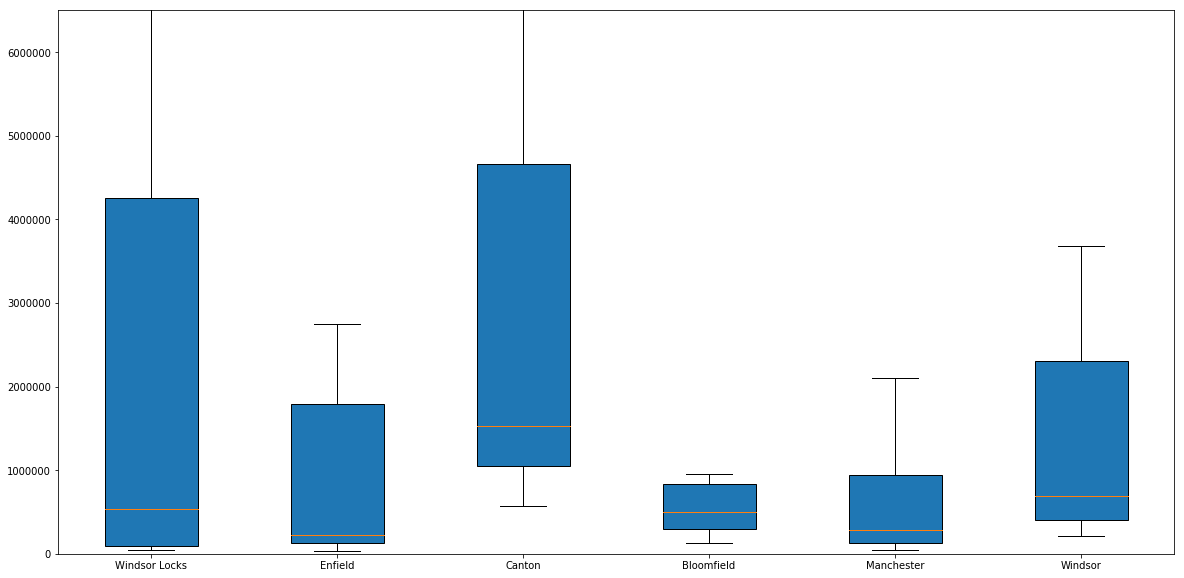

In [31]:
toplot = cityprices.groupby('City').mean()['SaleAmount'].sort_values(ascending=False)
toplot = pd.DataFrame(toplot)[:6]
subs=[]
lab=[]
for i in toplot.index:
    lab.append(i)
   
    vals = (cityprices[cityprices['City']==i]['SaleAmount'].values).astype('int32')
    subs.append(vals)

plt.figure(figsize=(20,10))
plt.gca().set_ylim(0, 6500000)
plt.boxplot(subs, sym='',patch_artist=True, labels=lab)


In [32]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)   #supress awful sci notation
avg= cityprices.groupby('City').mean().head(6)
avg.rename(columns={'SaleAmount': 'MeanPrice'}, inplace=True)
avg

,longitude,latitude,MeanPrice,StatDistance
City,,,,
Avon,-72.864,41.790,1445714.286,65.183
Berlin,-72.767,41.619,266666.667,65.086
Bloomfield,-72.726,41.833,3243661.538,65.045
Bristol,-72.934,41.682,2030586.325,65.252
Broad Brook,-72.544,41.909,2030586.325,64.862
Burlington,-72.946,41.758,754777.667,65.265


In [33]:
pd.reset_option('display.float_format')                 #back to normal number format

### Perform visualization for cities geographic dispersion,  the coordinates for the county are 41.763710, -72.685097

In [34]:

maphartford = folium.Map(location=[41.763710, -72.685097], zoom_start=9.8)
# add markers to map
for lat, lng, city in zip(cityprices['latitude'], cityprices['longitude'], cityprices['City']): 
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(maphartford)  
    folium.CircleMarker(
        [41.7688, -72.6816],
        radius=6,
        popup="Station",
        fill=True,
        fill_color='orange',
        fill_opacity=.9,
        parse_html=False).add_to(maphartford)
    
maphartford

## Retailers offering the products we distribute - ‘venueshartford’ data frame:

### Extract near venues from Foursquare, to include in the model the occurrence of venues of interest near each possible locations (5000m radius)

In [35]:
# Set keys and data for calling API
CLIENT_ID = 'OEIQPBBHFH2TRCVPE1OZOD1IHWMSGVMCATXOSKYKQ4XK0RXV' # your Foursquare ID
CLIENT_SECRET = '1BHTGTZUPAWPVHMKFVTD1YXZOGF024LQPAKJWR0FD0LLT5BK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OEIQPBBHFH2TRCVPE1OZOD1IHWMSGVMCATXOSKYKQ4XK0RXV
CLIENT_SECRET:1BHTGTZUPAWPVHMKFVTD1YXZOGF024LQPAKJWR0FD0LLT5BK


In [36]:
cityprices.head(7)

,City,Zip Code,longitude,latitude,SaleAmount,StatDistance
0,Avon,06001,-72.86431,41.789698,1800000.0,65.182714
1,Avon,06001,-72.86431,41.789698,600000.0,65.182714
2,Avon,06001,-72.86431,41.789698,2750000.0,65.182714
3,Avon,06001,-72.86431,41.789698,245000.0,65.182714
4,Avon,06001,-72.86431,41.789698,3300000.0,65.182714
5,Avon,06001,-72.86431,41.789698,600000.0,65.182714
6,Avon,06001,-72.86431,41.789698,825000.0,65.182714


In [37]:
#set the radius and limit of venues
setradius = 5000
setlimit = 200
# url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)

In [38]:
#try with one, this will be itarated for each city/town
lat = hartford_geo['latitude'][0]
lng = hartford_geo['longitude'][0]

In [39]:
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            setradius, 
            setlimit)

In [41]:
result = requests.get(url).json()["response"]['groups'][0]['items']
result[2]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '52b37ad4498ee519018a88b7',
  'name': "Moe's Southwest Grill",
  'location': {'address': '385 West Main Street',
   'lat': 41.815687089945854,
   'lng': -72.86426004578085,
   'labeledLatLngs': [{'label': 'display',
     'lat': 41.815687089945854,
     'lng': -72.86426004578085},
    {'label': 'entrance', 'lat': 41.815193, 'lng': -72.862714}],
   'distance': 2893,
   'postalCode': '06001',
   'cc': 'US',
   'city': 'Avon',
   'state': 'CT',
   'country': 'United States',
   'formattedAddress': ['385 West Main Street',
    'Avon, CT 06001',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c1941735',
    'name': 'Mexican Restaurant',
    'pluralName': 'Mexican Restaurants',
    'shortName': 'Mexican',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_',
     'suffix': '.png'},
    'primary

### Then, with a function, extract the relevant data, which is in nested dictionaries

In [42]:
# will iterate over harford_geo by unique zipcode, up to 200 venues in a 5000m range  
def getNearbyVenues(zipc, latitudes, longitudes, radius):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipc, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            setlimit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']   #same chosen nested info than 'venues'
        
        # return only relevant information for each nearby venue
        venues_list.append([(                 
            zipcode,                          #at this level the not nested, returns name of neighborhood
            lat,                              #at this level the not nested, returns lat of neighborhood
            lng,                              #at this level the not nested, returns lat of neighborhood   
            v['venue']['name'],               #gives tha name of establishment
            v['venue']['location']['lat'],    #as lat is in nested location dict, this is for the establishment
            v['venue']['location']['lng'],    #as lon is in nested location dict, this is for the establishment
            v['venue']['categories'][0]['name']) for v in results])   #vey nested, gives conpcept of establishment 
         
    venues_detail = []            
    for ezip in venues_list:      #iterate to get to list (first level) of the neighbohoods and all its venues
        for detailvenue in ezip:  #to get the tuples inside each venue
            venues_detail.append(detailvenue)
    
    nearby_venues = pd.DataFrame(venues_detail)    
    
    nearby_venues.columns = ['Zip Code', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### As the objective of the project is to evaluate different locations, the serch of nearby venues will be performed for each city within Hartford county. So the data frame hartford_geo willbe used, to get coordinates for each city.

In [43]:
venueshartford = getNearbyVenues(zipc=hartford_geo['Zip Code'],
                                   latitudes=hartford_geo['latitude'],
                                   longitudes=hartford_geo['longitude'],
                                   radius=setradius
                                  )

In [44]:
venueshartford.keys()

Index(['Zip Code', 'City Latitude', 'City Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

In [45]:
print('There is a total of {} vennes near the locations'.format(venueshartford.shape[0]))

There is a total of 3246 vennes near the locations



### At his point, it is important to determine how frequent is to find the specific venue categories (of reatilers) where the distribution has to reach. These specific venue categories are detailed in a list. 

In [46]:
# #define type of venues, relevant:
ofinterest = [
'Liquor Store',
'Grocery Store',
'Furniture / Home Store',
'Kitchen Supply Store',
'Department Store',
'Shopping Mall',
'Deli / Bodega', 
'Supermarket',
'Paper / Office Supplies Store',
'Convenience Store',
'Discount Store',
'Hardware Store', 
'Miscellaneous Shop', 
'Warehouse Store',
'Market']    
# #filter out all venues not in the list
mask1 = venueshartford['Venue Category'].isin(ofinterest)
venueshartford = venueshartford[mask1]

In [47]:
venueshartford.head()

,Zip Code,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,06001,41.789698,-72.86431,Liquor Depot,41.817013,-72.868958,Liquor Store
5,06001,41.789698,-72.86431,The Fresh Market,41.814060,-72.858722,Grocery Store
8,06001,41.789698,-72.86431,Bed Bath & Beyond,41.817309,-72.865027,Furniture / Home Store
11,06001,41.789698,-72.86431,Sur La Table,41.822472,-72.881385,Kitchen Supply Store
13,06001,41.789698,-72.86431,Bob's Stores,41.818682,-72.863818,Department Store


###  Then, the frequency of the reitailed venues to distribute, can be determined, for each city (remember that each zip code is unique for its correponding city):

In [48]:
# count frequency for each city
bycityfreq = venueshartford.groupby('Zip Code').count()
bycityfreq.head()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zip Code,,,,,,
06001,17,17,17,17,17,17
06002,11,11,11,11,11,11
06006,6,6,6,6,6,6
06010,10,10,10,10,10,10
06013,4,4,4,4,4,4


In [49]:
bycityfreq.drop(bycityfreq.columns[:5], 1, inplace=True)
bycityfreq.rename(columns={'Venue Category':'Venue Counts'}, inplace=True)
bycityfreq.tail()

,Venue Counts
Zip Code,
06444,9
06447,1
06467,8
06479,7
06489,7


In [50]:
print('There are {} protential retailers to whom distribute'.format(venueshartford.shape[0]))

There are 371 protential retailers to whom distribute


## Prices in Hartford county, with coordinates - ‘cityprices1’ data frame:

### Given that all data for analysis is gathered, it can just be integrated in one table

In [51]:
cityprices.head(10)

,City,Zip Code,longitude,latitude,SaleAmount,StatDistance
0,Avon,06001,-72.86431,41.789698,1800000.0,65.182714
1,Avon,06001,-72.86431,41.789698,600000.0,65.182714
2,Avon,06001,-72.86431,41.789698,2750000.0,65.182714
3,Avon,06001,-72.86431,41.789698,245000.0,65.182714
4,Avon,06001,-72.86431,41.789698,3300000.0,65.182714
5,Avon,06001,-72.86431,41.789698,600000.0,65.182714
6,Avon,06001,-72.86431,41.789698,825000.0,65.182714
7,Bloomfield,06002,-72.72642,41.832798,595000.0,65.044852
8,Bloomfield,06002,-72.72642,41.832798,500000.0,65.044852
9,Bloomfield,06002,-72.72642,41.832798,960000.0,65.044852


In [52]:
hartfordcl = cityprices
cityprices1 = pd.merge(cityprices, bycityfreq, on='Zip Code', how='inner')
cityprices1['SaleAmount'].apply(lambda x : "{:,}".format(x))
cityprices1.head(10)

,City,Zip Code,longitude,latitude,SaleAmount,StatDistance,Venue Counts
0,Avon,06001,-72.86431,41.789698,1800000.0,65.182714,17
1,Avon,06001,-72.86431,41.789698,600000.0,65.182714,17
2,Avon,06001,-72.86431,41.789698,2750000.0,65.182714,17
3,Avon,06001,-72.86431,41.789698,245000.0,65.182714,17
4,Avon,06001,-72.86431,41.789698,3300000.0,65.182714,17
5,Avon,06001,-72.86431,41.789698,600000.0,65.182714,17
6,Avon,06001,-72.86431,41.789698,825000.0,65.182714,17
7,Bloomfield,06002,-72.72642,41.832798,595000.0,65.044852,11
8,Bloomfield,06002,-72.72642,41.832798,500000.0,65.044852,11
9,Bloomfield,06002,-72.72642,41.832798,960000.0,65.044852,11


## Determining the number of clusters, K-means

### Use kmeans, looking for similarities based in the three relevant features chosen: real estate prices, proximity to more frequently used station and quantity of distribution venues. Elbow methid fir best k value:

Text(0, 0.5, 'Distance to centroid')

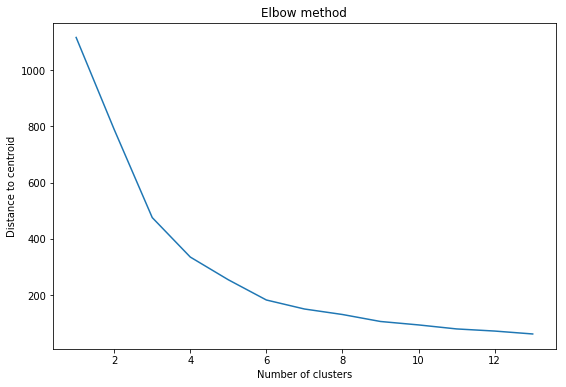

In [53]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = cityprices1.iloc[:,[4,5,6]].values
scaler = StandardScaler()
Xsc = scaler.fit_transform(X)

inertia=[]   #distance respect to its centroid
for i in range(1,14):
    kmean = KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmean.fit(Xsc)
    inertia.append(kmean.inertia_)

plt.figure(figsize=(9,6))
plt.plot(range(1,14), inertia)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Distance to centroid')

### It is possible to observe that increasing number of custers beyond 6, the decrease in distances to centroid starts to flatten. For this reason the chosen k is 6.

In [54]:
kclusters = 6
kmean6 = KMeans(n_clusters=kclusters, init='k-means++',random_state=0)
kmean6.fit(Xsc)
kmlabels = kmean6.labels_
kmlabels

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 1, 0, 0, 0, 4, 4, 0, 1, 3, 3, 3, 3, 3, 1, 3, 5,
       4, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2,
       5, 5, 5, 5, 4, 3, 0, 0, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

### Add column with cluster labels to data frame, and group by cluster

In [55]:
cityprices1['Labels'] = kmlabels
agg_clusters = cityprices1.groupby('Labels').mean()
agg_clusters['SaleAmount'] =agg_clusters['SaleAmount'].apply(lambda x : "{:,.1f}".format(x)) #avoid scy notation
agg_clusters

,longitude,latitude,SaleAmount,StatDistance,Venue Counts
Labels,,,,,
0,-72.807124,41.713834,"1,079,346.1",65.125573,15.072464
1,-72.521871,41.771109,"1,093,011.2",64.840289,6.260000
2,-72.604996,41.918199,"52,714,285.7",64.923615,11.000000
3,-72.679790,41.804220,"1,081,363.0",64.998237,7.153846
4,-72.879071,41.666106,"1,011,284.9",65.197640,6.447368
5,-72.563927,41.976495,"846,760.4",64.882684,15.038462


In [56]:
cityprices1.head()

,City,Zip Code,longitude,latitude,SaleAmount,StatDistance,Venue Counts,Labels
0,Avon,06001,-72.86431,41.789698,1800000.0,65.182714,17,0
1,Avon,06001,-72.86431,41.789698,600000.0,65.182714,17,0
2,Avon,06001,-72.86431,41.789698,2750000.0,65.182714,17,0
3,Avon,06001,-72.86431,41.789698,245000.0,65.182714,17,0
4,Avon,06001,-72.86431,41.789698,3300000.0,65.182714,17,0


In [58]:
#use Stamen Toner to have some contrast
map_clusters = folium.Map(location=[41.763710, -72.685097], zoom_start=9.7,tiles="Stamen Toner")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + 5*x + (i*x)**6 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cityprices1['latitude'], cityprices1['longitude'], cityprices1['City'], cityprices1['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    folium.CircleMarker(
        [41.7688, -72.6816],
        radius=6,
        popup="Station",
        fill=True,
        fill_color='orange',
        fill_opacity=0.2,
        parse_html=False).add_to(map_clusters)
       
map_clusters